# Imports

In [1]:
# imports

import os, sys
import numpy as np
import SimpleITK as sitk

from helpers_general import sitk2np, np2sitk, round_tuple, lrange, get_roi_range
from helpers_preprocess import mask2bbox, print_bbox, get_data_dict, folder2objs
from helpers_metrics import compute_dice_coefficient, compute_coverage_coefficient
from helpers_viz import viz_axis

In [2]:
# auto-reload when local helper fns change
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Data

In [3]:
PROJ_PATH = "."

# Folders containing MR train data
train_path = f"{PROJ_PATH}/train_data/train_data"
train_data_dict = get_data_dict(train_path)

# print train data dict
print(f"Train data folders: {os.listdir(train_path)}")
print(f"Training data: key = train folder, value = full path to (segm obj, nii file)\n")
print(*list(train_data_dict.items()), sep="\n")

Train data folders: ['50455', '50458', '50461', '50456', '50463', '50459', '50457', '50462', '50460', '50464']
Training data: key = train folder, value = full path to (segm obj, nii file)

('50455', ('./train_data/train_data/50455/Segmentation.obj', './train_data/train_data/50455/MP-RAGE/2000-01-01_00_00_00.0/S165455/ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii'))
('50458', ('./train_data/train_data/50458/Segmentation.obj', './train_data/train_data/50458/MP-RAGE/2000-01-01_00_00_00.0/S165212/ABIDE_50458_MRI_MP-RAGE_br_raw_20120830215600956_S165212_I329222.nii'))
('50461', ('./train_data/train_data/50461/Segmentation.obj', './train_data/train_data/50461/MP-RAGE/2000-01-01_00_00_00.0/S165203/ABIDE_50461_MRI_MP-RAGE_br_raw_20120830215105276_S165203_I329213.nii'))
('50456', ('./train_data/train_data/50456/Segmentation.obj', './train_data/train_data/50456/MP-RAGE/2000-01-01_00_00_00.0/S164657/ABIDE_50456_MRI_MP-RAGE_br_raw_20120830174547173_S164657_I328667.nii'))
('5

### Load Atlas

Preproccessing makes isotropic.

In [4]:
# isotropic preprocessing param
iso_spacing      = (1,1,1)
iso_interpolator = sitk.sitkLinear # sitk.sitkBSline

# set fixed MR
atlas_folder = "50456"
atlas_obj, atlas_mask_obj = folder2objs(atlas_folder, train_data_dict, iso_spacing, iso_interpolator)

In [10]:
print("#"*10, f"Atlas MR", "#"*10)
print(f"Shape: {atlas_obj.GetSize()}")
print(f"Spacing: {round_tuple(atlas_obj.GetSpacing())}")
print(f"Orientation: {round_tuple(atlas_obj.GetDirection())}")
print("#"*10, f"Atlas ROI", "#"*10)
atlas_mask_arr = sitk2np(atlas_mask_obj)
atlas_bbox_coords = mask2bbox(atlas_mask_arr)
print_bbox(*atlas_bbox_coords)

########## Atlas MR ##########
Shape: (192, 240, 256)
Spacing: (1.0, 1.0, 1.0)
Orientation: (1.0, -0.026, 0.0, -0.026, -1.0, 0.0, 0.0, 0.0, 1.0)
########## Atlas ROI ##########
Bbox coords: (78, 116, 120) to (107, 140, 136). Size: 29, 24, 16.
Bounding box coord: from location (116, 120) of slice 78 to location (140, 136) of slice 107.


### Load Input

In [6]:
# isotropic preprocessing param
iso_spacing      = (1,1,1)
iso_interpolator = sitk.sitkLinear # sitk.sitkBSline

# set moving MR
input_folder = "50455"
input_obj, input_mask_obj = folder2objs(input_folder, train_data_dict, iso_spacing, iso_interpolator)

In [12]:
print("#"*10, f"Atlas MR", "#"*10)
print(f"Shape: {atlas_obj.GetSize()}")
print(f"Spacing: {round_tuple(atlas_obj.GetSpacing())}")
print(f"Orientation: {round_tuple(atlas_obj.GetDirection())}")

print("#"*10, f"Atlas ROI", "#"*10)
print_bbox(*atlas_bbox_coords)

print("#"*10, f"Input ROI", "#"*10)
input_mask_arr = sitk2np(input_mask_obj)
input_bbox_coords = mask2bbox(input_mask_arr)
print_bbox(*input_bbox_coords)

########## Atlas MR ##########
Shape: (192, 240, 256)
Spacing: (1.0, 1.0, 1.0)
Orientation: (1.0, -0.026, 0.0, -0.026, -1.0, 0.0, 0.0, 0.0, 1.0)
########## Atlas ROI ##########
Bbox coords: (78, 116, 120) to (107, 140, 136). Size: 29, 24, 16.
Bounding box coord: from location (116, 120) of slice 78 to location (140, 136) of slice 107.
########## Input ROI ##########
Bbox coords: (78, 114, 103) to (111, 142, 120). Size: 33, 28, 17.
Bounding box coord: from location (114, 103) of slice 78 to location (142, 120) of slice 111.


### Viz Moving Image + Mask

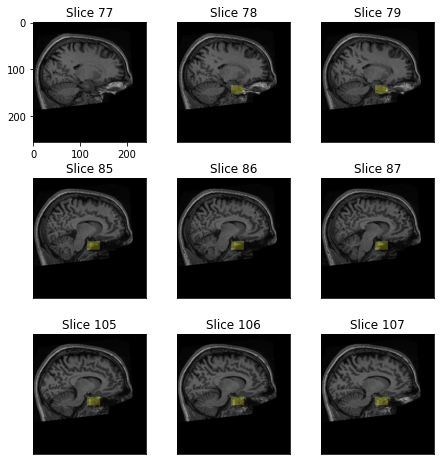

In [9]:
# Bbox is between 78-107 along axis 0.
slice_range = lrange(77,80) + lrange(85,88) + lrange(105,108)
viz_axis(sitk2np(input_obj), \
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [3, 3], hspace=0.3, fig_mult=2)

### Crop to sella only

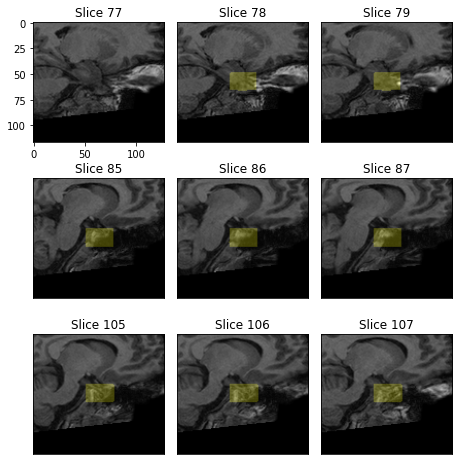

In [13]:
# viz just the sella
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = input_bbox_coords, crop_extra=50,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [3, 3], hspace=0.3, fig_mult=2)

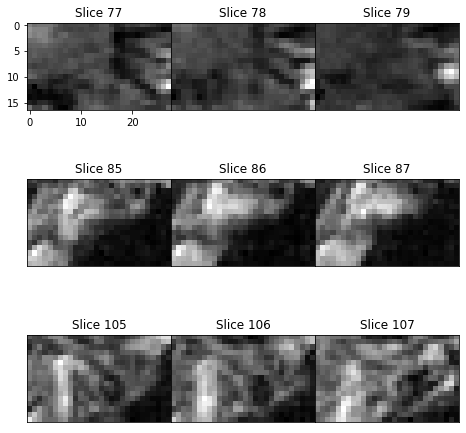

In [14]:
# viz just the sella
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = input_bbox_coords, crop_extra=0,
        #bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [3, 3], hspace=0.3, fig_mult=2)

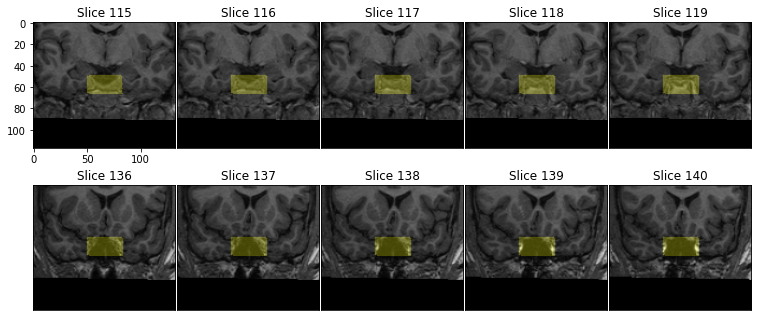

In [15]:
# viz just the sella, coronal
# Bbox coords: (78, 116, 120) to (107, 140, 136). Size: 29, 24, 16.

slice_range = lrange(115, 120) + lrange(136,141)
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = input_bbox_coords, crop_extra=50,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=1, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

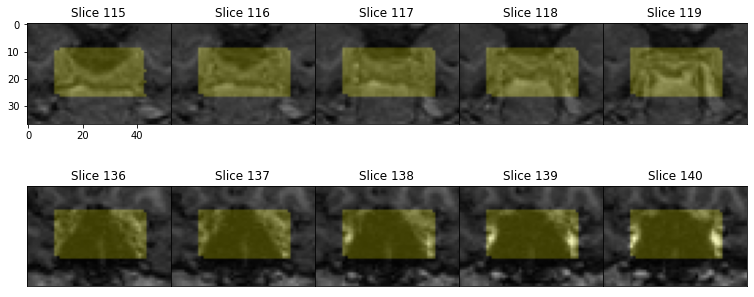

In [16]:
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = input_bbox_coords, crop_extra=10,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=1, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

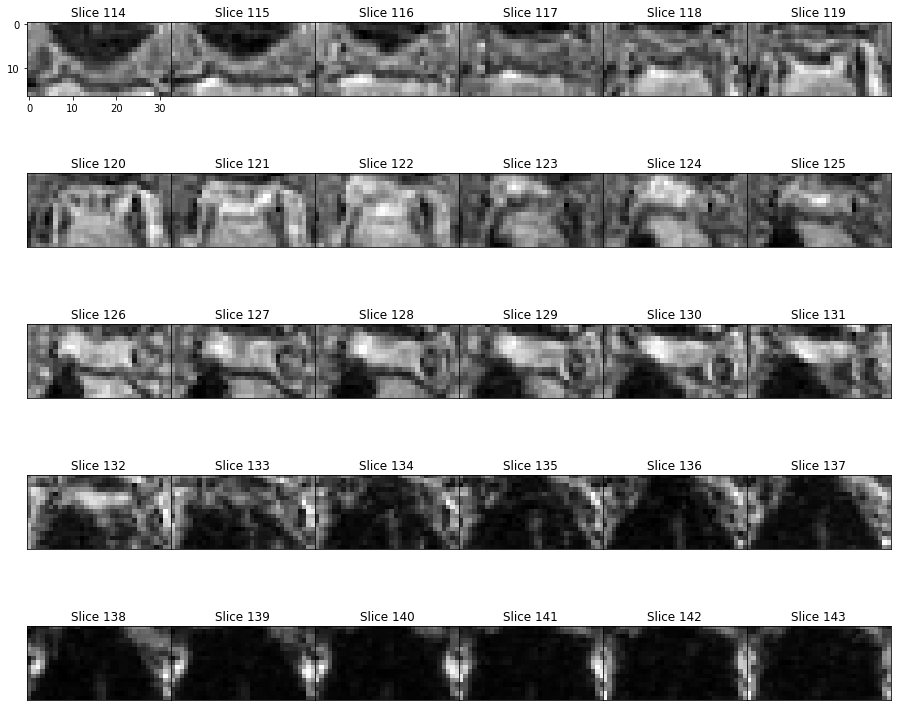

In [61]:
slice_range = lrange(114, 144)
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = input_bbox_coords, crop_extra=0,
        #bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=1, \
        axis_fn = np.rot90, \
        grid = [5, 6], hspace=0.3, fig_mult=2)

# Elastix Registration

## Rigid Alignment

- Rigid: "rigid body, which can translate and rotate, but cannot be
scaled/stretched."

- Similarity: "translate, rotate, and scale isotropically."

- Affine: "translated, rotated, scaled,
and sheared."

### ROI Mapping
Elastix convention: Resampling $moving \to fixed$ image involves a transformation $T: fixed \to moving$. $T$ maps coordinates in the fixed image domain to the corresponding coordinates in the moving image. Resampling a moving image onto the fixed image coordinate system involves:
1. Apply $T$ to fixed image voxel coordinates $x$ to get corresponding coordinates $y$ in the moving domain: $y = T(x) \in I_M$.
2. Estimate the voxel intensities $v$ at the moving image coordinates $y \in I_m$ via (linear) interpolation from nearby moving image voxel intensities.
3. Set the voxel intensities $v$ at the fixed image coordinates $x \in I_F$ to the above moving image voxel intensities.

Source: 5.0.1 Elastix Manual

In [18]:
def align_and_tfm(fixed_obj, moving_obj, moving_mask_obj, \
                  param_folder = "ElastixParamFiles", param_files = ["affine.txt", "bspline.txt"]):
    
    # ALIGN ATLAS AND INPUT IMAGE
    
    # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_obj)
    elastixImageFilter.SetMovingImage(moving_obj)
    
    # set parameter map
    parameterMapVector = sitk.VectorOfParameterMap()
    for param_file in param_files:
        parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    # Execute alignment
    elastixImageFilter.Execute()

    # MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

    # set moving image (atlas)                                                    
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetMovingImage(moving_mask_obj)
                    
    # set parameter map (Binary mask => nearest neighbor final interpolation)
    transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
    transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

    # Execute transformation
    transformixImageFilter.Execute()
    
    return transformixImageFilter.GetResultImage()

In [20]:
# Align the atlas and the input MR. Resample atlas ROI onto input ROI (fixed: input, moving: atlas). 
pred_mask_obj = align_and_tfm(input_obj, atlas_obj, atlas_mask_obj, \
                              param_folder = "ElastixParamFiles", param_files = ["affine.txt"])

In [22]:
# Evaluate predicted input ROI
gt_mask_arr = input_mask_arr

#gt_mask_arr   = sitk2np(gt_mask_obj).astype(bool)
pred_mask_arr = sitk2np(pred_mask_obj).astype(bool)

In [23]:
dice     = compute_dice_coefficient(gt_mask_arr, pred_mask_arr)
coverage = compute_coverage_coefficient(gt_mask_arr, pred_mask_arr)
bbox_coords = mask2bbox(pred_mask_arr)

In [30]:
print({"dice": f"{dice:0.2f}", "coverage": f"{coverage:0.2f}"})
print_bbox(*bbox_coords)

{'dice': '0.59', 'coverage': '0.53'}
Bbox coords: (79, 112, 106) to (109, 140, 128). Size: 30, 28, 22.
Bounding box coord: from location (112, 106) of slice 79 to location (140, 128) of slice 109.


In [51]:
print("Affine: ", bbox_coords)
print("GT: ", input_bbox_coords)

Affine:  (79, 109, 112, 140, 106, 128)
GT:  (78, 111, 114, 142, 103, 120)


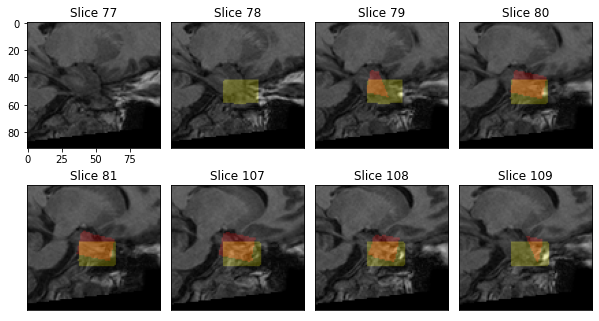

In [57]:
# Viz affine
slice_range = lrange(77, 82) + lrange(107,112)

viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bbox_coords, crop_extra=35,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 4], hspace=0.3, fig_mult=2)

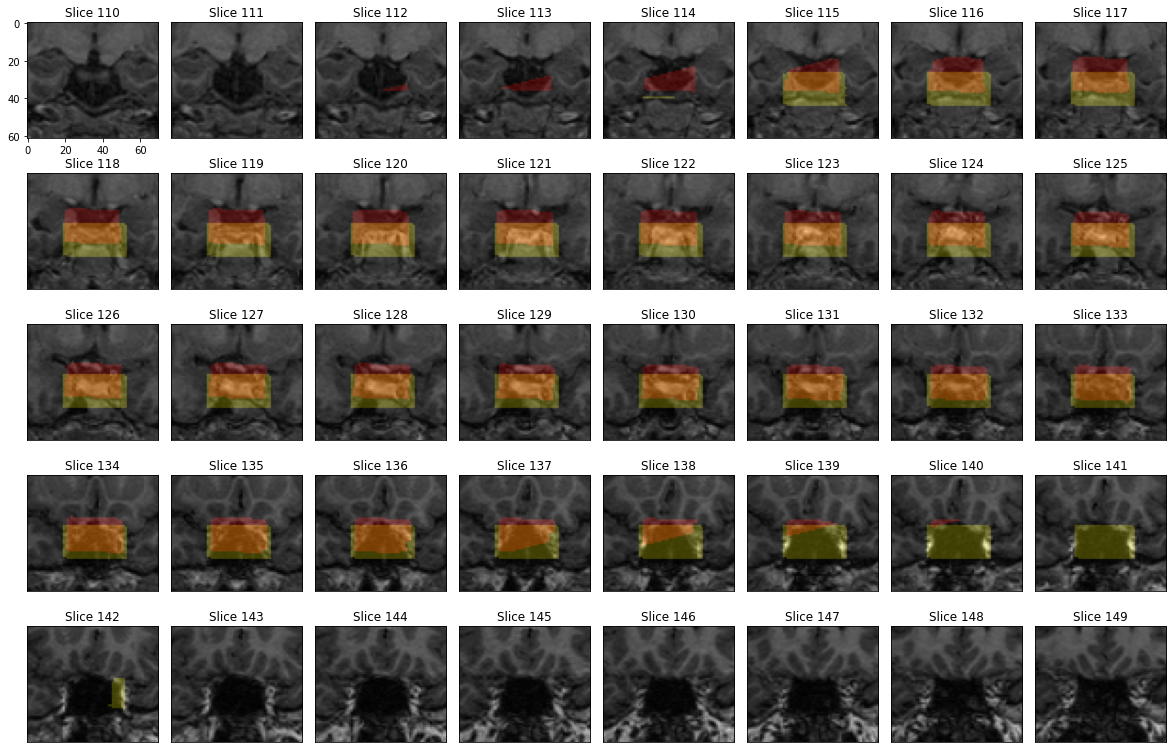

In [62]:
slice_range = lrange(110, 150)
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bbox_coords, crop_extra=20,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=1, \
        axis_fn = np.rot90, \
        grid = [5, 8], hspace=0.3, fig_mult=2)

In [31]:
# Align the atlas and the input MR. Resample atlas ROI onto input ROI (fixed: input, moving: atlas). 
bspline_pred_mask_obj = align_and_tfm(input_obj, atlas_obj, atlas_mask_obj, \
                              param_folder = "ElastixParamFiles", param_files = ["affine.txt", "bspline.txt"])

In [33]:
# Evaluate predicted input ROI
bspline_pred_mask_arr = sitk2np(bspline_pred_mask_obj).astype(bool)

bspline_dice     = compute_dice_coefficient(gt_mask_arr, bspline_pred_mask_arr)
bspline_coverage = compute_coverage_coefficient(gt_mask_arr, bspline_pred_mask_arr)
bspline_bbox_coords = mask2bbox(bspline_pred_mask_arr)

print({"dice": f"{bspline_dice:0.2f}", "coverage": f"{bspline_coverage:0.2f}"})
print_bbox(*bspline_bbox_coords)

{'dice': '0.54', 'coverage': '0.45'}
Bbox coords: (78, 111, 107) to (109, 143, 130). Size: 31, 32, 23.
Bounding box coord: from location (111, 107) of slice 78 to location (143, 130) of slice 109.


In [46]:
print("Affine: ", bbox_coords)
print("+Bspline: ", bspline_bbox_coords)
print("GT: ", input_bbox_coords)

Affine:  (79, 109, 112, 140, 106, 128)
+Bspline:  (78, 109, 111, 143, 107, 130)
GT:  (78, 111, 114, 142, 103, 120)


In [55]:
print("Ground Truth GT")
print_bbox(*input_bbox_coords)

print("Affine only")
print_bbox(*bbox_coords)

print("+Bspline")
print_bbox(*bspline_bbox_coords)

Ground Truth GT
Bbox coords: (78, 114, 103) to (111, 142, 120). Size: 33, 28, 17.
Bounding box coord: from location (114, 103) of slice 78 to location (142, 120) of slice 111.
Affine only
Bbox coords: (79, 112, 106) to (109, 140, 128). Size: 30, 28, 22.
Bounding box coord: from location (112, 106) of slice 79 to location (140, 128) of slice 109.
+Bspline
Bbox coords: (78, 111, 107) to (109, 143, 130). Size: 31, 32, 23.
Bounding box coord: from location (111, 107) of slice 78 to location (143, 130) of slice 109.


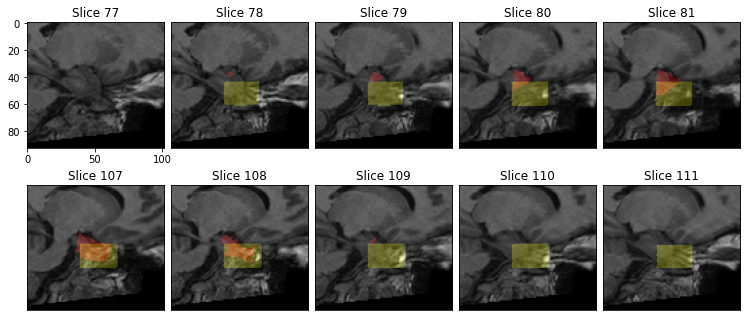

In [56]:
# Viz affine + bspline
slice_range = lrange(77, 82) + lrange(107,112)

viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bspline_bbox_coords, crop_extra=35,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = bspline_pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

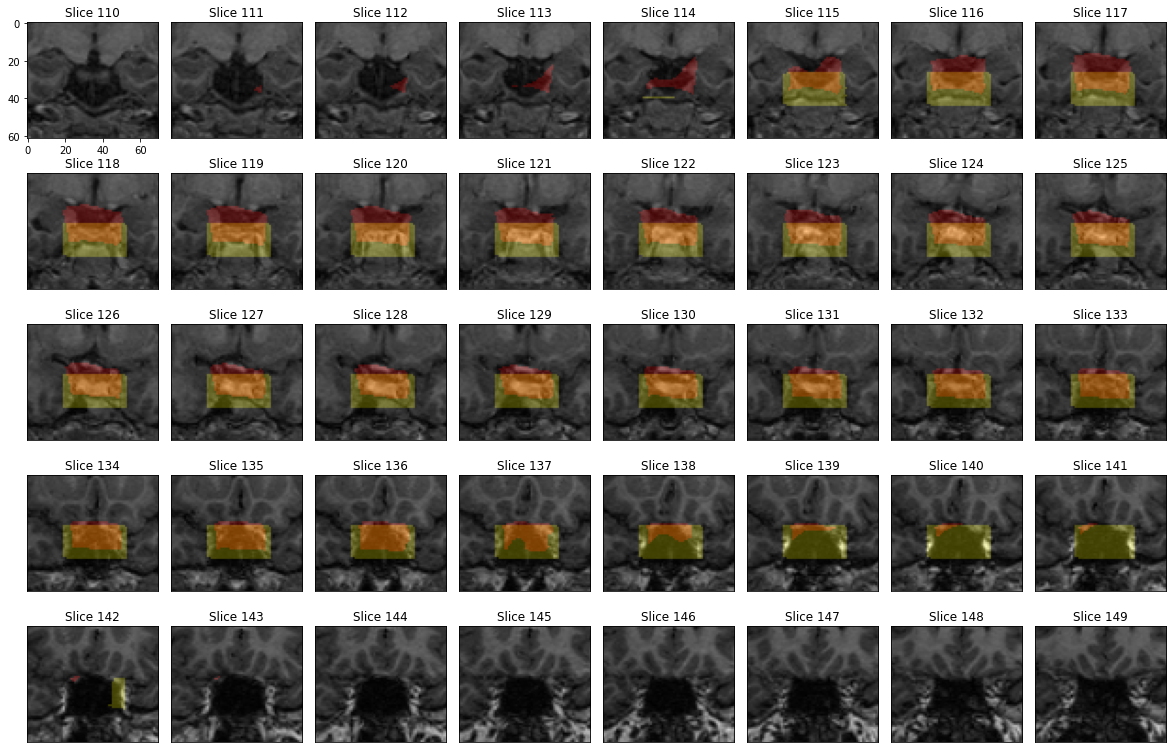

In [63]:
slice_range = lrange(110, 150)
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bbox_coords, crop_extra=20,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = bspline_pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=1, \
        axis_fn = np.rot90, \
        grid = [5, 8], hspace=0.3, fig_mult=2)

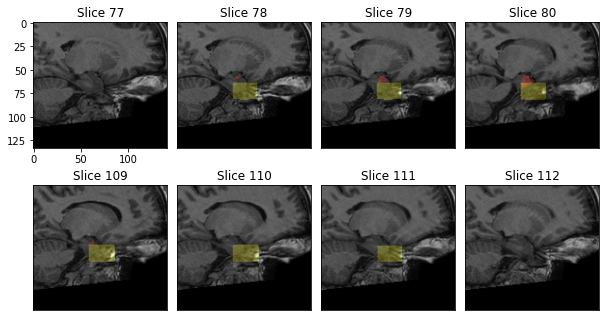

In [54]:
slice_range = [77,78,79, 80] + [109,110,111,112]

viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bspline_bbox_coords, crop_extra=55,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = bspline_pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 4], hspace=0.3, fig_mult=2)

# Affine non-whole brain

Focus alignment on generated input ROI

In [ ]:
# pad slices by 5, crop extra bbox by 10vox x 10vox

In [ ]:
def crop_extra_mask(bin_mask_arr, crop_coords, slice_pad, vox_pad, fixed_axis=06):
    imin, imax, jmin, jmax, kmin, kmax = crop_coords
    if fixed_axis == 0:   
        jmin -= pad; jmax += pad; kmin -= pad; kmax += pad;
        np_arr = np_arr[:, jmin:jmax, kmin:kmax]
        if bin_mask_arr is not None:  bin_mask_arr  = bin_mask_arr[:, jmin:jmax, kmin:kmax]
        if bin_mask_arr2 is not None: bin_mask_arr2 = bin_mask_arr2[:, jmin:jmax, kmin:kmax]

    elif fixed_axis == 1: 
        imin -= pad; imax += pad; kmin -= pad; kmax += pad;
        np_arr = np_arr[imin:imax, :, kmin:kmax]
        if bin_mask_arr is not None:  bin_mask_arr  = bin_mask_arr[imin:imax, :, kmin:kmax]
        if bin_mask_arr2 is not None: bin_mask_arr2 = bin_mask_arr2[imin:imax, :, kmin:kmax]

    else:
        imin -= pad; imax += pad; jmin -= pad; jmax += pad;
        np_arr = np_arr[imin:imax, jmin:jmax, :]
        if bin_mask_arr is not None:  bin_mask_arr  = bin_mask_arr[imin:imax, jmin:jmax, :]
        if bin_mask_arr2 is not None: bin_mask_arr2 = bin_mask_arr2[imin:imax, jmin:jmax, :]

In [ ]:
pred_mask_obj

In [ ]:
# Align the atlas and the input MR. Resample atlas ROI onto input ROI (fixed: input, moving: atlas). 
pred_mask_obj = align_focused(input_obj, pred_roi, atlas_obj, atlas_mask_obj, \
                              param_folder = "ElastixParamFiles", param_files = ["affine.txt"])

In [ ]:
def align_focused(fixed_obj, fixed_mask_obj, moving_obj, moving_mask_obj, \
                  param_folder = "ElastixParamFiles", param_files = ["affine.txt", "bspline.txt"]):
    
    # ALIGN ATLAS AND INPUT IMAGE
    
    # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_obj)
    elastixImageFilter.SetMovingImage(moving_obj)
    
    # set masks
    elastixImageFilter.SetFixedMask(fixed_mask_obj)
    elastixImageFilter.SetMovingMask(moving_mask_obj)
    
    
    # set parameter map
    parameterMapVector = sitk.VectorOfParameterMap()
    for param_file in param_files:
        parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    # Execute alignment
    elastixImageFilter.Execute()

    # MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

    # set moving image (atlas)                                                    
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetMovingImage(moving_mask_obj)
                    
    # set parameter map (Binary mask => nearest neighbor final interpolation)
    transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
    transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

    # Execute transformation
    transformixImageFilter.Execute()
    
    return transformixImageFilter.GetResultImage()

### Viz Mapped ROI

In [43]:
print(transformed_input_mask_arr.shape)

transformed_input_bbox_coords = mask2bbox(transformed_input_mask_arr)
print_bbox(*transformed_input_bbox_coords)

(192, 240, 256)
Bbox coords: (76, 116, 112) to (111, 147, 134). Size: 35, 31, 22.
Bounding box coord: from location (116, 112) of slice 76 to location (147, 134) of slice 111.


Compare bounding boxes

In [44]:
print(f"Original Moving Mask"), print_bbox(*input_bbox_coords);
print(f"ROI contains {np.count_nonzero(input_mask_arr)} elements.", "\n");

print(f"Target Fixed Mask"), print_bbox(*atlas_bbox_coords);
print(f"ROI contains {np.count_nonzero(atlas_mask_arr)} elements.", "\n");

print(f"Transformed Moving Mask"), print_bbox(*transformed_input_bbox_coords);
print(f"ROI contains {np.count_nonzero(transformed_input_mask_arr)} elements.", "\n");

Original Moving Mask
Bbox coords: (78, 114, 103) to (111, 142, 120). Size: 33, 28, 17.
Bounding box coord: from location (114, 103) of slice 78 to location (142, 120) of slice 111.
ROI contains 16538 elements. 

Target Fixed Mask
Bbox coords: (78, 116, 120) to (107, 140, 136). Size: 29, 24, 16.
Bounding box coord: from location (116, 120) of slice 78 to location (140, 136) of slice 107.
ROI contains 12504 elements. 

Transformed Moving Mask
Bbox coords: (76, 116, 112) to (111, 147, 134). Size: 35, 31, 22.
Bounding box coord: from location (116, 112) of slice 76 to location (147, 134) of slice 111.
ROI contains 16070 elements. 



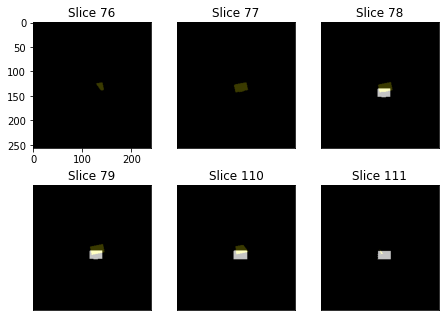

In [45]:
viz_axis(input_mask_arr, bin_mask_arr=transformed_input_mask_arr, 
        slices=lrange(76, 80) + lrange(110,112), atlas_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 3], hspace=0.3, fig_mult=2, cmap0="gray")

### Coronal

In [77]:
sitk2np(iso_atlas_obj).shape

(192, 240, 256)

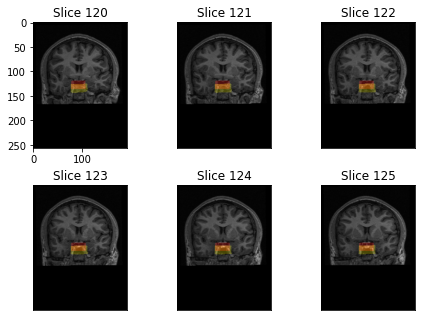

In [46]:
viz_axis(sitk2np(atlas_obj), \
        bin_mask_arr=transformed_input_mask_arr, color1 = "yellow", \
        bin_mask_arr2=atlas_mask_arr, color2 = "red", \
        slices=lrange(120, 126), atlas_axis=1, \
        axis_fn = np.rot90, \
        grid = [2, 3], hspace=0.3, fig_mult=2, cmap0="gray")

## Sagittal

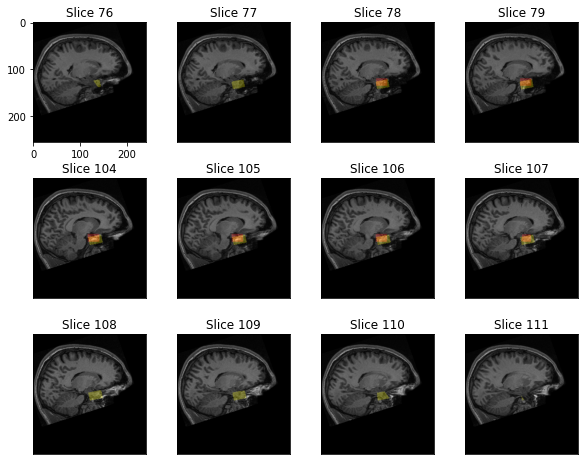

In [48]:
#cmap1 = [white, yellow]; cmap2 = [white, blue]
viz_axis(sitk2np(atlas_obj), \
        bin_mask_arr=transformed_input_mask_arr, color1 = "yellow", \
        bin_mask_arr2=atlas_mask_arr, color2 = "red", \
        slices=lrange(76, 80) + lrange(104,112), atlas_axis=0, \
        axis_fn = np.rot90, \
        grid = [3, 4], hspace=0.3, fig_mult=2, cmap0="gray")

# Old

In [39]:
def affine_align(fixed_obj, fixed_mask_obj, moving_obj, moving_mask_obj, param_file = "AffineParamFile.txt"):
    
    # map moving => fixed (the transform is fixed => moving)
    #parameterMap = sitk.GetDefaultParameterMap('affine')
    parameterMap  = sitk.ReadParameterFile(param_file)
    
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_obj)
    elastixImageFilter.SetMovingImage(moving_obj)
    
    # focus on registering moving mask ROI
    #elastixImageFilter.SetMovingMask(moving_mask_obj)
    #parameterMap["ImageSampler"] = ["RandomSparseMask"]
   
    # print param map
    sitk.PrintParameterMap(parameterMap)
    
    elastixImageFilter.SetParameterMap(parameterMap)
    elastixImageFilter.Execute()

    transformed_moving_obj  = elastixImageFilter.GetResultImage()
    transformedParameterMap = elastixImageFilter.GetTransformParameterMap()[0]
    
    # Binary mask => nearest neighbor
    transformedParameterMap["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    
    # map ROI of moving => fixed
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(transformedParameterMap)
    transformixImageFilter.SetMovingImage(moving_mask_obj)
    transformixImageFilter.Execute()
    
    transformed_moving_mask_obj = transformixImageFilter.GetResultImage()

    # evaluate: dice, coverage
    fixed_mask_arr              = sitk2np(fixed_mask_obj).astype(bool)
    transformed_moving_mask_arr = sitk2np(transformed_moving_mask_obj).astype(bool)

    dice     = compute_dice_coefficient(fixed_mask_arr, transformed_moving_mask_arr)
    coverage = compute_coverage_coefficient(fixed_mask_arr, transformed_moving_mask_arr)
    
    # save bounding box coords
    bbox_coords = mask2bbox(transformed_moving_mask_arr)
        
    return dice, coverage, bbox_coords, transformed_moving_obj, transformed_moving_mask_arr

In [ ]:
dice, coverage, bbox_coords, transformed_input_obj, transformed_input_mask_arr = affine_align(atlas_obj, atlas_mask_obj, input_obj, input_mask_obj)

In [ ]:
print(f"Dice: {dice}. Coverage {coverage}.")
print_bbox(*bbox_coords)